## Introduction du projet et objectif

### Introduction du projet

Nom du projet : Prédiction de pannes

Projet réalisé par : Angelo Ouedraogo

Date de réalisation : 22/05/2025

Origine du dataset : Kaggle (mettre le lien)

Motif du projet : Projet personnel

### Objectif du projet 

Ce projet utilise un jeu de données qui suit l'état de santé d'un certain nombre d'appareils grâce à neuf métriques jusqu'à leur panne ou la fin de la période d'observation. 

L'objectif ce projet est de pouvoir prédire la durée d'utilisation restante d'un appareil avant une panne (ou obsolescence) à partir des métriques ou de l'historique des métriques sur quelques jours. 



## Importation des bibliothèques nécessaires

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import random
import joblib

## Importation et pré-traitement des données 

### Importation et premières informations

In [2]:
data = pd.read_csv("predictive_maintenance_dataset.csv")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   date     124494 non-null  object
 1   device   124494 non-null  object
 2   failure  124494 non-null  int64 
 3   metric1  124494 non-null  int64 
 4   metric2  124494 non-null  int64 
 5   metric3  124494 non-null  int64 
 6   metric4  124494 non-null  int64 
 7   metric5  124494 non-null  int64 
 8   metric6  124494 non-null  int64 
 9   metric7  124494 non-null  int64 
 10  metric8  124494 non-null  int64 
 11  metric9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [3]:
data.isna().sum()

date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

Le premier constat à effectuer est sur les valeurs manquantes. On remarque donc qu'il n'y a aucune action à faire à ce sujet car on a 124494 observations et pour chaque variable on a autant d'entrées non-null. On revérifie quand même avec la fonction isna.  
On remarque ensuite que la variable 'date' est de type object, ce qui ne nous permettra pas de faire les opérations sur les dates (différence entre deux dates par exemple), alors nous devrions convertir cette colonne de notre dataframe en colonne de type datetime. 

#### Conversion de notre colonne 'date' en type datetime

In [4]:
data["date"] = pd.to_datetime(data["date"], format="%m/%d/%Y")

### Etude plus fine du dataset

Une fois cette conversion faite, on peut alors tirer de premières informations générales sur notre jeu de données.

In [5]:
print(f"Il y a {len(data)} observations concernant un total de {len(data['device'].unique())} appareils différents.")
print(f"La période s'étend du {data['date'].min().strftime('%d/%m/%Y')} au {data['date'].max().strftime('%d/%m/%Y')}, soit {(data['date'].max() - data['date'].min()+pd.Timedelta(days=1)).days} jours.")

Il y a 124494 observations concernant un total de 1169 appareils différents.
La période s'étend du 01/01/2015 au 02/11/2015, soit 306 jours.


On a alors 9 métriques définies par des entiers permettant d'évaluer l'état de 1169 appareils (identifiés par un code) sur une étendue de 305 jours. Ayant l'impression que les métriques 7 et 8 sont souvent égales, analysons donc la corrélation entre les métriques pour vérifier qu'elles sont toutes utiles et indépendantes. 

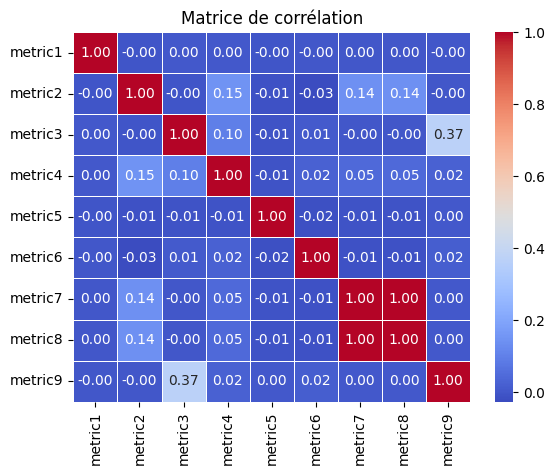

In [6]:
metrics = data.drop(["date", "device", "failure"], axis=1)
corr = metrics.corr()
#plt.figure(figsize=(8, 6))
sbn.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Matrice de corrélation")
plt.show()

In [7]:
print(f" La différence absolue maximale entre les observations des métriques 7 et 8 vaut {np.abs(data['metric7']-data['metric8']).max()}")

 La différence absolue maximale entre les observations des métriques 7 et 8 vaut 0


On remarque donc une corrélation maximale qui s'avère être une égalité entre les métriques 7 et 8. Il est donc inutile de conserver les deux à la fois, nous faisons alors le choix arbitraire de supprimer la métrique 8. Concernant les autres métriques, on constate très vite sur la heatmap qu'elles sont toutes indépendantes, donc à conserver. 

In [8]:
data = data.drop("metric8", axis=1)

On s'intéresse ensuite  à la durée et au nombre d'observations par appareil. 

In [9]:
result = data.groupby("device")["date"].agg(lambda x: x.max() - x.min()+pd.Timedelta(days=1))
result.sort_index()

device
S1F01085     6 days
S1F013BB     6 days
S1F0166B     6 days
S1F01E6Y    48 days
S1F01JE0     6 days
             ...   
Z1F1VMZB   292 days
Z1F1VQFY   181 days
Z1F26YZB    84 days
Z1F282ZV    84 days
Z1F2PBHX    96 days
Name: date, Length: 1169, dtype: timedelta64[ns]

In [10]:
print((data['device'].value_counts()).sort_index())

diff = (data['device'].value_counts()).sort_index() - result.dt.days
print(f"Le nombre d'apparils utilisés de façon discontinue est {np.count_nonzero(diff)}.")


device
S1F01085      6
S1F013BB      6
S1F0166B      6
S1F01E6Y     48
S1F01JE0      6
           ... 
Z1F1VMZB    292
Z1F1VQFY    125
Z1F26YZB     84
Z1F282ZV     84
Z1F2PBHX     83
Name: count, Length: 1169, dtype: int64
Le nombre d'apparils utilisés de façon discontinue est 173.


On observe donc que certains appareils ne sont pas utilisés sur toute l'étendue de la période étudiée. 
On peut remarquer également la discontinuité dans l'utilisation pour 173 appareils (par exemple l'appareil Z1F1VQFY) qui n'apparaissent pas certains jours, on peut supposer alors qu'il y a une rotation mise en place ou que certains équipements spécifiques ne sont pas utilisés tous les jours. Cette différence peut être intéressante à considérer, on peut donc rajouter le nombre de jours d'utilisation comme métrique. 

In [11]:
data["use_days"] = data.groupby("device")["date"].transform(lambda x: x.rank(method="dense").astype(int))

On poursuit notre première analyse avec les failures. En regardant le dataset, on remaque assez vite que seulement une petite partie tombent réellement en panne. Affichons alors les noms des appareils qui tombent finalement en panne. 

In [12]:
print(data[data['failure'] == 1]['device'])


4885      S1F0RRB1
6879      S1F0CTDN
8823      W1F0PNA5
11957     W1F13SRV
12668     W1F1230J
            ...   
109927    W1F1CB5E
114251    Z1F0MRPJ
122118    S1F0JGJV
122808    Z1F14BGY
124329    W1F0T0B1
Name: device, Length: 106, dtype: object


Sur les 1169 appareils, seuls 106 tombent en panne sur l'étendue des 305 jours. Ceci n'exclut pas le fait que les autres appareils puissent être tombés en panne au delà de la période d'observation. Notre étude par du principe que tous les appareils tombent en panne, alors nous allons réduire notre jeu de données aux 106 appareils qui tombent réellement en panne. 

In [13]:
Data_failed = data 
Failures = Data_failed.groupby('device').agg({'failure' : 'max'})
Failures = Failures.rename(columns=({'failure': 'relevant'}))
Data_failed = Data_failed.merge(Failures, how='left', on='device')
Data_failed = Data_failed[Data_failed['relevant']==1]
Data_failed = Data_failed.reset_index(drop=True)
Data_failed = Data_failed.drop(['relevant'], axis=1)
#Data_failed = Data_failed.drop('device', axis=1)

In [14]:
print(f"Il y a {len(Data_failed)} observations concernant un total de {len(Data_failed['device'].unique())} appareils différents.")
print(f"La période s'étend du {Data_failed['date'].min().strftime('%d/%m/%Y')} au {Data_failed['date'].max().strftime('%d/%m/%Y')}, soit {(Data_failed['date'].max() - Data_failed['date'].min()+pd.Timedelta(days=1)).days} jours.")

Il y a 10713 observations concernant un total de 106 appareils différents.
La période s'étend du 01/01/2015 au 26/10/2015, soit 299 jours.


On reprend alors les informations de base sur notre dataset. On n'a plus que 10713 observations pour les 106 appareils et une période réduite à 298 jours car tous les appareils utilisés au delà du 26/10/2015 ne sont pas tombés en panne entre cette date et le 02/11/2015 (date de fin d'observation). 

On exporte notre dataset en fichier Excel pour faire une étude par appareil grâce à un dashboard Power BI, qui est plus pratique que Python pour cet aspect. 

In [15]:
Data_failed.to_csv("Failed_devices_dataset_new.csv")

## Remaining Useful Life (RUL)

Le Remaining Uselful Life est la durée d'utilisation restante d'un appareil. Elle sera notre variable d'intérêt mais elle n'apparait pas encore dans notre dataset, nous allons donc la calculer et l'ajouter au dataset pour pouvoir travailler dessus. On l'obtient en soutrayant la date d'observation à la date de panne.

### Calcul du RUL

In [16]:
Data_failed['date_max'] = Data_failed.groupby("device")['date'].transform('max')
Data_failed['RUL'] = Data_failed['date_max'] - Data_failed['date']
Data_failed["RUL"] = Data_failed["RUL"].dt.days
Data_failed = Data_failed.drop(["date_max"], axis=1)

## Mise en place des modèles 

J'ai voulu tester un premier modèle sans grande réflexion pour avoir une idée de la qualité et la richesse des données. Je me suis alors lancé sur un réseau de neurones Multi-Layer Perceptron (car je l'ai déjà utilisé plusieurs fois) pour prédire directement le RUL en fonction des métriques, sans prendre en compte les dépendances temporelles. 

### Neural Network on RUL value

On crée alors notre ensemble de variables explicatives X en prenant le soin d'enlever la date, le nom du device, la variable failure et le RUL qu'on place dans y (la variable cible). On standardise pour mettre toutes les variables à la même échelle et on sépare notre dataset en jeu d'entrainement et jeu de test.

In [17]:
X_raw = Data_failed.drop(['date', 'device', 'failure', 'RUL'], axis=1)
y = Data_failed['RUL']
X = StandardScaler().fit_transform(X_raw)
X_train, X_test, y_train, y_test = train_test_split(X,y)

On entraine alors notre modèle MLP (choix des couches arbitraire) tout en sachant qu'il sera très compliqué de prédire de manière exacte le RUL. 

In [18]:
model_mlp = MLPClassifier(hidden_layer_sizes=(400, 300, 300, 300, 300, 300, 400), max_iter=1000, random_state=42, activation='relu', solver='adam')
model_mlp.fit(X_train, y_train)

# Prédictions sur les données de test
predictions_mlp = model_mlp.predict(X_test)

# Évaluation de l'efficacité du modèle
accuracy_mlp = accuracy_score(y_test, predictions_mlp)
print(f'Test accuracy pour MLPclassifier: {accuracy_mlp}')

ecart = predictions_mlp - y_test
ecart_abs = np.abs(ecart)
print(f'ecart aboslu moyen: {np.mean(ecart_abs)}')
print(f'ecart absolu inférieur à 10: {(ecart_abs < 10).sum()} sur un total de {len(ecart_abs)} prédictions')

Test accuracy pour MLPclassifier: 0.03844718178424785
ecart aboslu moyen: 9.180291153415453
ecart absolu inférieur à 10: 2451 sur un total de 2679 prédictions


Comme prévu, l'accuracy est quasiment nulle. Mais ce qui est intéressant à regarder ici c'est l'écart absolu à la bonne valeur. On a un écart abolu moyen de moins 9 jours, ce qui est plutôt encourageant. On a également 2449 prédictions sur un total de 2679 (soit plus de 90%) qui sont assez proches (à moins de 10 jours) de la bonne valeur. Pour faire un planning de mainteance prédictive il est inutile d'avoir le RUL au jour près, mais savoir si l'appareil risque de tomber en panne sous 10 ou 15 jours par exemple (l"échelle se modifie à notre guise mais l'important est l'idée d'un plage). 

Pour exploiter cette idée, nous alors créer des classes de criticité en fonction du RUL. Cela permettra d'avoir une plage étendue plutôt qu'un nombre difficilement prévisible avec précision. On pourra donc tester un algorithme de classification comme le random forest. 

### Création de classes

Il y a énormément de façon de découper le RUL en classes, que ce soit le nombre de classes ou les seuils de criticité. Le plus important est de conserver une interprétabilité et une cohérence, alors un nombre de classes de 3 ou 4 semble adapté. Concernant les seuils, une discussion avec le corps métier est nécessaire pour avoir des seuils correspondant au planning de maintenance, ou au moins pertinents pour créer ce planning. Par exemple un classe avec un RUL entre 0 et 60 jours pourrait garantir une précision très proche de 100% mais serait pratiquement inutilisable. 

In [19]:
#conditions = [(Failed['RUL'] < 8), (Failed['RUL'] < 15), (Failed['RUL'] < 31)]
conditions = [(Data_failed['RUL'] < 16), (Data_failed['RUL'] < 31), (Data_failed['RUL'] < 46)]
values = ['Critique', 'Important', 'Modere']
Data_failed['Criticité'] = np.select(conditions, values, default='Secondaire')
Failed_class = Data_failed.drop('RUL', axis=1)

J'ai fixé les seuils à 15 jours, 30 jours et 45 jours estimant que, de prime abord, ces chiffres sont cohérents avec un planning de maintenance tout en ayant le potentiel d'aboutir à un modèle assez précis (en fonction des chiffres obtenus après le MLP). Ces choix seront évidemment à rediscuter avec le corps métier.

### Classification

On sépare notre dataset en jeu d'entrainement et jeu de test. 

In [20]:
y = Failed_class['Criticité']
X_train, X_test, y_train, y_test = train_test_split(X,y)

#### Random Forest

In [21]:
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train, y_train)
from sklearn.metrics import accuracy_score, confusion_matrix
print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, model_rf.predict(X_test))*100} %")

Le pourcentage de bien classés est de : 97.42441209406495 %


#### Discussion sur les métriques

On obtient une accuracy de 96%, ce qui est un très bon résultat. L'accuracy est une métrique qui permet de mesurer la qualité globale de notre modèle mais elle n'est pas la plus pertiennte ici. La classe 'critique' étant la plus importante à prendre en compte, notre modèle doit être évalué sur sa capacité à capter un maximum de cas critiques. Pour ce faire, on va donc évaluer notre modèle avec la métrique Recall (le rappel) sur la classe critique, tout en ayant un regard sur le Recall des autres classes. 

Le Recall se calcule en divisant le nombre de vrais critiques prédits par le nombre réel de critiques. 

In [22]:
matrice_confusion = pd.DataFrame(confusion_matrix(y_test, model_rf.predict(X_test)),
             index = ["Critique_données", "Important_données", "Modere_données", "Secondaire_données"],
             columns = ["Critique_predit", "Important_predit", "Modere_predit", "Secondaire_predit"])
matrice_confusion

,Critique_predit,Important_predit,Modere_predit,Secondaire_predit
Critique_données,361,10,0,8
Important_données,9,267,13,4
Modere_données,0,9,246,10
Secondaire_données,2,0,4,1736


In [23]:
classes = ["Critique", "Important", "Modere", "Secondaire"]
for i in range(4):
    print(f"Le recall de la classe {classes[i]} pour le random forest vaut {recall_score(y_test, model_rf.predict(X_test), average= None)[i]}.")

Le recall de la classe Critique pour le random forest vaut 0.9525065963060686.
Le recall de la classe Important pour le random forest vaut 0.9112627986348123.
Le recall de la classe Modere pour le random forest vaut 0.9283018867924528.
Le recall de la classe Secondaire pour le random forest vaut 0.9965556831228473.


Notre modèle capte donc 94% des appareils en classe critique ce qui est très satisfaisant. Ensuite on capte respectivement 88% et 87% pour les classes important et modéré et enfin 99% pour la clsse secondaire. 

On peut même nuancer le score des classes intermédiaires car le plus imprtant est de ne pas sous-évaluer notre appareil. En effet, si la maintenance d'un appareil est effectuée 10 jours en avance ce n'est pas un drame tant que le taux du surévaluation reste raisonnable, et on préfère largement le faire 10 jours en avance plutôt que 10 jours en retard. On peut donc créer un nouvelle métrique en comptant le nombre de bien classés ou surclassés, donc le nombre d'appareils qui seront pris en charge au moins à temps (ou en avance). 

Nb : nous allons enlever la catégorie "Secondaire" pour calculer nos métriques car elle a une importance moindre mais un très gros impact sur les calculs.

In [24]:
# Calculer la somme cumulée des lignes
somme_cumulee = matrice_confusion.drop('Secondaire_données').cumsum(axis=1)

# Diviser chaque ligne par la somme totale de cette ligne
print(f"Le pourcentage d'appareils qui seront pris en charge à temps (ou en avance) est {(np.diag(somme_cumulee)).sum() / matrice_confusion.drop('Secondaire_données').sum().sum() * 100} %.")
print(f"Le pourcentage d'appareils qui seront pris en charge en avance est {(np.diag(somme_cumulee, k=-1)).sum() / matrice_confusion.drop('Secondaire_données').sum().sum()} %.")

Le pourcentage d'appareils qui seront pris en charge à temps (ou en avance) est 95.1974386339381 %.
Le pourcentage d'appareils qui seront pris en charge en avance est 0.0192102454642476 %.


Notre modèle permet donc de prendre 92% des appareils en charge à temps avec un très faible taux de prises en charge prématurée. On peut donc être satisfait de ce modèle en gardant à l'esprit la perspective d'amélioration.

### Temporalité

Une perpective d'améliration est la prise en compte de la temporalité de nos données. En effet, les modèles utilisés jusque-là ne prenaient pas en compte le fait que nos données soient en réalité des séries temporelles. Une façon pertinente de le prendre un compte est de partir sur un RNN.

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

In [26]:

from sklearn.utils.class_weight import compute_class_weight


#### Transformation en séries temporelles

In [27]:
data = Data_failed.copy()

encoder = OrdinalEncoder(categories=[["Critique", "Important", "Modere","Secondaire"]])  
encoded = encoder.fit_transform(np.array(Data_failed['Criticité']).reshape(-1, 1))
Data_failed['Criticité_encoded'] = encoded.astype(int)

# Sélection des colonnes utiles
features = ["metric1", "metric2", "metric3", "metric4", "metric5", "metric6", "metric7", "metric9", "use_days"]  # Remplace par les bonnes métriques
target = "Criticité_encoded"

# Normalisation des données
#scaler = MinMaxScaler()
#Data_failed[features] = scaler.fit_transform(Data_failed[features])

# Conversion en séquences temporelles
sequence_length = 3  # Nombre de jours historiques utilisés pour la prédiction
X, y = [], []

# Création d'un dictionnaire contenant les groupes par device
grouped_devices = Data_failed.groupby('device')

X, y = [], []

for device, Data_device in grouped_devices:
    for i in range(len(Data_device) - sequence_length):
        X.append(Data_device[features].iloc[i:i+sequence_length].values)
        y.append(Data_device[target].iloc[i+sequence_length])

X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [48]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y= y_train)

# Convertir en dictionnaire pour Keras
class_weight_dict = dict(zip(classes, class_weights))
class_weight_dict[0] = 2


model_rnn = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32),
    Dense(1)  # Prédiction du RUL
])

model_rnn.compile(loss='mse', optimizer='adam')

model_rnn.fit(X_train, y_train, epochs=100, batch_size=2, class_weight=class_weight_dict)

predictions_rnn = model_rnn.predict(X_test)

# Évaluation de l'efficacité du modèle
#accuracy_rnn = accuracy_score(y_test, predictions_rnn)
#print(f'Test accuracy pour RNN: {accuracy_rnn}')


Epoch 1/100


d:\Mini-Projet-3-Prediction-de-pannes\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3898/3898 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 1.4055
Epoch 2/100
3898/3898 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1.3865
Epoch 3/100
3898/3898 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.3670
Epoch 4/100
3898/3898 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.3769
Epoch 5/100
3898/3898 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1.3768
Epoch 6/100
3898/3898 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.4028
Epoch 7/100
3898/3898 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.3825
Epoch 8/100
3898/3898 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.3927
Epoch 9/100
3898/3898 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1.3844
Epoch 10/100
3898/3898 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.3954
Epoch 11/100
3898/3898 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1.3600
Epoch 12/100
3898/3898 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.3890
Epoch 13/100
3898/3898 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.3522
Epoch 14/100
3898/3898 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.3816
Epoch 15/100


In [ ]:
#INUTILE
ecart = predictions_rnn.flatten() - y_test
ecart_abs = np.abs(ecart)
print(f'ecart aboslu moyen: {np.mean(ecart_abs)}')
print(f'ecart absolu inférieur à 10: {(ecart_abs < 10).sum()} sur un total de {len(ecart_abs)} prédictions')

ecart aboslu moyen: 0.952364611300013
ecart absolu inférieur à 10: 2599 sur un total de 2599 prédictions


In [44]:
prediction= predictions_rnn.round().astype(int).flatten()
prediction= np.maximum(prediction, 0)


In [45]:
confusion_matrix(y_test, prediction)

array([[   1,    3,  352,    1],
       [   1,    2,  303,    2],
       [   0,    0,  268,    0],
       [   2,   11, 1651,    2]])

In [46]:
pd.DataFrame(confusion_matrix(y_test, prediction),
             index = ["Critique_données", "Important_données", "Modere_données", "Secondaire_données"],
             columns = ["Critique_predit", "Important_predit", "Modere_predit", "Secondaire_predit"])

,Critique_predit,Important_predit,Modere_predit,Secondaire_predit
Critique_données,1,3,352,1
Important_données,1,2,303,2
Modere_données,0,0,268,0
Secondaire_données,2,11,1651,2


In [47]:
classes = ["Critique", "Important", "Modere", "Secondaire"]
for i in range(4):
    print(f"Le recall de la classe {classes[i]} pour le random forest vaut {recall_score(y_test, prediction, average= None)[i]}.")

Le recall de la classe Critique pour le random forest vaut 0.0028011204481792717.
Le recall de la classe Important pour le random forest vaut 0.006493506493506494.
Le recall de la classe Modere pour le random forest vaut 1.0.
Le recall de la classe Secondaire pour le random forest vaut 0.0012004801920768306.


Malgré plusieurs paramétrages différents du RNN j'ai obtenu des résultats décevants compte-tenu du fait que la temporalité rajoute une information supplémentaire permettant de capter non seulement la valeur de la métrique mais aussi son évolution sur les derniers jours, mais en effet la complexité de l'apprentissage. Le projet reste en cours j'essayerais donc d'autres méthodes prenant en compte la temporalité.